In [4]:
import pathlib
import datetime
import json
from collections import defaultdict
import pathlib
import os
import random

from readability import Readability
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.cm import get_cmap
import pandas as pd
import ollama
import numpy as np
import joypy

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 30

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rc('font', **{'family': 'serif', 'serif': ['Times New Roman']})

CWD = pathlib.Path("").parent
REPORT_DIR = CWD / 'data' / 'reports' / '2025-02-14-21-09-38-kmeans-openai-gpt-4o'
EVAL_DIR = CWD / 'data' / 'evals'
NUM_OF_TRIALS = 5

In [5]:
# Load the LLM evaluations
assignment_names = ['Suffrage', 'GatesS', 'GatesT']
all_evals = []
for assignment_name in assignment_names:
    evals = pd.read_excel(REPORT_DIR / assignment_name / 'llm_evaluation' / 'evaluations.xlsx')
    evals['assignment'] = assignment_name
    all_evals.append(evals)
evals = pd.concat(all_evals)

# Rename columns to improve readability
prior_attributes = ['clarity', 'relevance', 'coherence', 'actionability', 'depth_of_insight', 'specificity', 'engagement', 'bias_and_fairness', 'use_of_evidence']
attributes = ['Clarity', 'Relevance', 'Coherence', 'Actionability', 'Depth of Insight', 'Specificity', 'Engagement', 'Bias and Fairness', 'Use of Evidence']
for prior_attribute, attribute in zip(prior_attributes, attributes):
    evals = evals.rename(columns={prior_attribute: attribute})
evals.head(10)

,Clarity,Relevance,Coherence,Actionability,accuracy,Depth of Insight,Specificity,Engagement,Bias and Fairness,Use of Evidence,assignment
0,4,5,4,3,5,4,4,3,5,5,Suffrage
1,4,5,4,4,5,3,5,4,5,5,Suffrage
2,4,5,4,5,5,4,4,4,5,5,Suffrage
3,4,5,5,4,5,4,4,3,5,5,Suffrage
4,4,4,3,4,5,3,3,3,5,4,Suffrage
0,3,4,3,4,4,4,3,3,5,4,GatesS
1,3,4,3,4,4,4,4,3,4,4,GatesS
2,4,5,4,4,5,4,4,3,5,5,GatesS
3,3,4,3,4,4,3,4,3,5,4,GatesS
4,4,5,4,5,5,4,5,4,5,5,GatesS


/var/folders/wg/5f3q13d11215w5syssg034n80000gn/T/ipykernel_2943/1571072982.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assignment_series.iloc[0] = assignment_series.iloc[0] - 0.2
/var/folders/wg/5f3q13d11215w5syssg034n80000gn/T/ipykernel_2943/1571072982.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.8' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  assignment_series.iloc[0] = assignment_series.iloc[0] - 0.2
/var/folders/wg/5f3q13d11215w5syssg034n80000gn/T/ipykernel_2943/1571072982.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

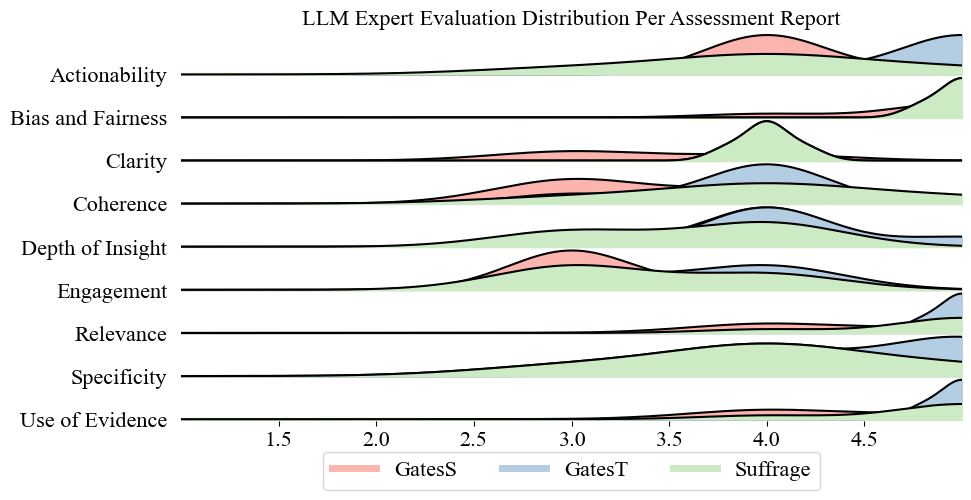

In [7]:
# Within each of the assignment columns, include the list of values as a numpy array
new_dict = defaultdict(list)
for i in range(len(attributes)):
    for j in range(NUM_OF_TRIALS):
        new_dict['Rating Type'].append(attributes[i])
        for assignment_name in assignment_names:
            assignment_df = evals[evals['assignment'] == assignment_name]
            row = assignment_df[attributes[i]].iloc[j]
            new_dict[assignment_name].append(row)

new_df = pd.DataFrame(new_dict)

# If an assignment's attribute values are all the same, we need to add some noise to the values
for attribute in attributes:
    attribute_df = new_df[new_df['Rating Type'] == attribute]
    for assignment_name in assignment_names:
        assignment_series = attribute_df[assignment_name]
        if len(assignment_series.unique()) == 1:
            # assignment_series = assignment_series + np.random.normal(0, 0.025, len(assignment_series))
            # Add -0.1 and 0.1 to the first two values
            assignment_series.iloc[0] = assignment_series.iloc[0] - 0.2
            assignment_series.iloc[1] = assignment_series.iloc[1] + 0.2
            new_df.loc[attribute_df.index, assignment_name] = assignment_series

# Make 'Suffrage' the last column instead of the 1st column
new_df = new_df[['Rating Type', 'GatesS', 'GatesT', 'Suffrage']]

# Define colors for each assignment
# colors = {'Suffrage': "#4C72B0", 'GatesS': "#DD8452", 'GatesT': "#55A868"}
# joyplot_colors = ['orange', 'blue', 'green']

# Get pastel colors for the joyplot
# cmap = get_cmap('tab20')
cmap = get_cmap('Pastel1')
joyplot_colors = [cmap(i) for i in range(3)]
colors = {'GatesS': joyplot_colors[0], 'GatesT': joyplot_colors[1], 'Suffrage': joyplot_colors[2]}

# Ridgeline plot of LLM evaluations
# new_df_only_suffjrage = new_df[['Suffrage', 'Rating Type']]
# print(new_df_only_suffrage.head(10))
fix, ax = joypy.joyplot(
    new_df, 
    title="LLM Expert Evaluation Distribution Per Assessment Report", 
    by='Rating Type', 
    # grid=True, 
    linecolor="black", 
    ylim='own', 
    x_range=[1,5], 
    overlap=0.1,
    figsize=(10, 5),
    color=joyplot_colors
)

# Create a custom legend using Line2D
legend_elements = [Line2D([0], [0], color=color, lw=5, label=label) for label, color in colors.items()]

# Add manual legend
plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=len(colors))
# plt.tight_layout()
plt.savefig(EVAL_DIR / 'llm_evaluations_joyplot.png')
plt.show()

# sns.set_theme(style="white")
# g = sns.FacetGrid(new_df, row="Rating Type", aspect=9, height=1.2)
# g.map_dataframe(sns.kdeplot, x="Suffrage")